# San Francisco Bike Share Prediction Model 

I have done a previous analysis on bike share data of San Francisco where I extracted trends and patterns from the data. I found a different set of ride share data that that has a few new columns, which will come in handy when creating a prediction model. I want to create a model that will predict how many bike rides are taken on a daily basis, as a continuation of the analysis. Highly recommed taking a look at it, https://github.com/medmorales/Data-Exploration/blob/main/Lyft%20Analysis/BikeShareAnalysis.ipynb.



## Packages

In [195]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt

## Loading in the data

In [155]:
station =  pd.read_csv('station.csv')
status =  pd.read_csv('status.csv')
trip =  pd.read_csv('trip.csv')
weather =  pd.read_csv('weather.csv')

## Trips DataFrame
The trips file has the bulk of our data. This is very similar to the data that I did an exploratory analysis on as mentioned at the top of this file. I highly reccomend to take a look at it. https://github.com/medmorales/Data-Exploration/blob/main/Lyft%20Analysis/BikeShareAnalysis.ipynb

In [3]:
trip.head()

,id,duration,start_date,start_station_name,start_station_id,end_date,end_station_name,end_station_id,bike_id,subscription_type,zip_code
0,4576,63,8/29/2013 14:13,South Van Ness at Market,66,8/29/2013 14:14,South Van Ness at Market,66,520,Subscriber,94127
1,4607,70,8/29/2013 14:42,San Jose City Hall,10,8/29/2013 14:43,San Jose City Hall,10,661,Subscriber,95138
2,4130,71,8/29/2013 10:16,Mountain View City Hall,27,8/29/2013 10:17,Mountain View City Hall,27,48,Subscriber,97214
3,4251,77,8/29/2013 11:29,San Jose City Hall,10,8/29/2013 11:30,San Jose City Hall,10,26,Subscriber,95060
4,4299,83,8/29/2013 12:02,South Van Ness at Market,66,8/29/2013 12:04,Market at 10th,67,319,Subscriber,94103


In [4]:
trip.dtypes

id                     int64
duration               int64
start_date            object
start_station_name    object
start_station_id       int64
end_date              object
end_station_name      object
end_station_id         int64
bike_id                int64
subscription_type     object
zip_code              object
dtype: object

In [5]:
trip.describe()

,id,duration,start_station_id,end_station_id,bike_id
count,669959.000000,6.699590e+05,669959.000000,669959.000000,669959.000000
mean,460382.009899,1.107950e+03,57.851876,57.837438,427.587620
std,264584.458487,2.225544e+04,17.112474,17.200142,153.450988
min,4069.000000,6.000000e+01,2.000000,2.000000,9.000000
25%,231082.500000,3.440000e+02,50.000000,50.000000,334.000000
50%,459274.000000,5.170000e+02,62.000000,62.000000,440.000000
75%,692601.000000,7.550000e+02,70.000000,70.000000,546.000000
max,913460.000000,1.727040e+07,84.000000,84.000000,878.000000


In [6]:
trip.nunique()

id                    669959
duration               16129
start_date            361559
start_station_name        74
start_station_id          70
end_date              357757
end_station_name          74
end_station_id            70
bike_id                  700
subscription_type          2
zip_code                7439
dtype: int64

Here I just wanted to see the number of unique values in the data frame to gain a better understanding of the number of stations, subscription types, etc..

In [7]:
#### Missing Data 
np.round(trip.isnull().sum()/len(trip)*100, decimals =2)

id                    0.00
duration              0.00
start_date            0.00
start_station_name    0.00
start_station_id      0.00
end_date              0.00
end_station_name      0.00
end_station_id        0.00
bike_id               0.00
subscription_type     0.00
zip_code              0.99
dtype: float64

As we can see, the zip code column has about 1% of it's data missing. I think it'll be intersting to see if there is a pattern for these missing zip codes so that we can populated the missing values. 

My mind questions if they are more isolated to only some stations, possibly to a subscription type or an end station maybe? Let's take a closer look at these rows...

In [ ]:
# isolating rows with missing zip codes
missing_zip = trip[trip['zip_code'].isnull()]
missing_zip.head()

### Duration: Lets explore the duration of the trips. 

In [201]:
# The duration uses the units seconds, I want to change this to minutes for clarity.
trip['duration']= trip['duration']/60

In [202]:
trip.duration.describe()

count    669959.000000
mean         18.465831
std         370.923950
min           1.000000
25%           5.733333
50%           8.616667
75%          12.583333
max      287840.000000
Name: duration, dtype: float64

From this output and our original analysis, we know that there are outliers in the data. Especially seeing the trip with the highest duration being one that lasted 287,840 minutes. I do no think it is realistic for someone to have taken a 287,840 minute bike ride, so the outliers might be the result of recording errors. Therefore, I will look into removing them prior to running the model. 

### Start Date
The start_date column will be essential to our model as it will be the date at which we will use to count the number of daily trips, our Dependent (x) variable that we will be predicting.  

In [24]:
# transform object type to datetime
trip.start_date = pd.to_datetime(trip.start_date, format='%m/%d/%Y %H:%M')

### Trip Duration Outlier Detection and Removal 

For the most part, when detecting and removing outliers, we use one of two main methods, using the Z-Score or Interquartile Range.

##### Z-Score

The z-score is the number of standard deviations that a value of an observation is above or below the mean value of the observations that are being measured. 

The formula is given by: $ z = (x - mean) / sd $

Using the Z-score comes with having the assumption that the data is has a Gaussian Distribution, also known as a Normal distribution. 

In finding the z-score, we rescale and center the data, and look for data points that are too far away from the mean. In this case we will use a threshold of 3 standard deviations away from the new mean. Any data point passed 3 SD will be considered an outlier. 

In [222]:
# Removing Outliers
df = trip[np.abs(stats.zscore(trip["duration"])) < 3]

In [223]:
df.shape

(669220, 11)

In [224]:
df.describe()

,id,duration,start_station_id,end_station_id,bike_id
count,669220.000000,669220.000000,669220.000000,669220.000000,669220.000000
mean,460459.242009,15.603581,57.866933,57.850430,427.648861
std,264573.852449,43.052706,17.100393,17.188535,153.373374
min,4069.000000,1.000000,2.000000,2.000000,9.000000
25%,231217.750000,5.733333,50.000000,50.000000,334.000000
50%,459422.500000,8.600000,62.000000,62.000000,440.000000
75%,692661.250000,12.566667,70.000000,70.000000,546.000000
max,913460.000000,1130.133333,84.000000,84.000000,878.000000


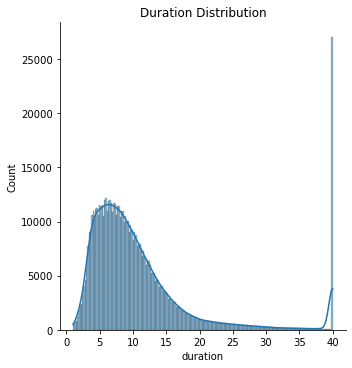

In [295]:
# DISTRIBUTION OF PREMIUM PRICES
sns.displot(x= np.clip(df.duration, 0,40), data = df, bins = 200, kde= True)
# sns.displot('duration', data = trip, bins = 20, kde= True)
plt.title('Duration Distribution')
plt.show()

### Extracting Date and Caluclating Daily Counts

In [132]:
# Extracting date from start time
trip["only_date"] = [d.date() for d in trip["start_date"]]

In [133]:
# Calculating daily trips and creating new dataframe. 
daily_count = pd.DataFrame(trip['only_date'].value_counts().reset_index())
daily_count.columns = ['dates', 'num_trips']

In [298]:
# sort the dataframe by date
train_data = daily_count.sort_values('dates')
train_data.reset_index(drop = True, inplace = True)

In [299]:
print('The trips data has a date range between ' + str(train_data.dates.min()) 
      + ' and '+ str(train_data.dates.max()) + '.')

The trips data has a date range between 2013-08-29 and 2015-08-31.


In [300]:
train_data

,dates,num_trips
0,2013-08-29,748
1,2013-08-30,714
2,2013-08-31,640
3,2013-09-01,706
4,2013-09-02,661
...,...,...
728,2015-08-27,1443
729,2015-08-28,1220
730,2015-08-29,342
731,2015-08-30,331


Now, we have successfuly calculated the number of bike rides per day given the date range in the Trip's dataset. This will be the focus of our model, predicting the number of trips, given the date. 

In [259]:
daily_count.reset_index(drop=True, inplace=True) 

In [260]:
daily_count

,dates,num_trips
0,2013-08-29,748
1,2013-08-30,714
2,2013-08-31,640
3,2013-09-01,706
4,2013-09-02,661
...,...,...
728,2015-08-27,1443
729,2015-08-28,1220
730,2015-08-29,342
731,2015-08-30,331


## Station DataFrame

Looking at the station dataframe, I think there is a great way to make use of it. Stations have different installation dates, meaning that the amount of bikes available to take for ride share has changed over time because they have built additional stations over time. So, an important variable in predicting the number of bike rides by date has to be the number of open docks at the time.  

So, lets calculate the number of docks at each date and combine that to our train_data set which is our modeling dataset. 

In [306]:
station.head()

,id,name,lat,long,dock_count,city,installation_date
0,2,San Jose Diridon Caltrain Station,37.329732,-121.901782,27,San Jose,2013-08-06
1,3,San Jose Civic Center,37.330698,-121.888979,15,San Jose,2013-08-05
2,4,Santa Clara at Almaden,37.333988,-121.894902,11,San Jose,2013-08-06
3,5,Adobe on Almaden,37.331415,-121.893200,19,San Jose,2013-08-05
4,6,San Pedro Square,37.336721,-121.894074,15,San Jose,2013-08-07


In [307]:
station.describe()

,id,lat,long,dock_count
count,70.000000,70.000000,70.000000,70.000000
mean,43.000000,37.590243,-122.218416,17.657143
std,24.166092,0.203473,0.209446,4.010442
min,2.000000,37.329732,-122.418954,11.000000
25%,24.250000,37.389483,-122.400601,15.000000
50%,43.500000,37.631163,-122.312123,15.000000
75%,63.750000,37.788123,-122.078009,19.000000
max,84.000000,37.804770,-121.877349,27.000000


In [308]:
station.nunique()

id                   70
name                 70
lat                  70
long                 70
dock_count            6
city                  5
installation_date    17
dtype: int64

#### Transforming and Extracting the Installation Date

In [310]:
# Extracting date from instillation time
# transform object type to datetime
station.installation_date = pd.to_datetime(station.installation_date, format='%m%d%Y')
station["installation_date"] = [d.date() for d in station["installation_date"]]

ValueError: time data '2013-08-06' does not match format '%m-%d-%Y' (match)

In [241]:
station['installation_date']

0     2013-08-06
1     2013-08-05
2     2013-08-06
3     2013-08-05
4     2013-08-07
         ...    
65    2013-08-25
66    2013-12-31
67    2014-01-22
68    2014-02-20
69    2014-04-09
Name: installation_date, Length: 70, dtype: object

In [305]:
print('The stations data has a date range between ' + str(station.installation_date.min()) 
      + ' and '+ str(station.installation_date.max()) + '.')

The stations data has a date range between 2013-08-05 and 2014-04-09.


Now, going back to what was interesting about this dataframe, calculating the dock counts for each date. So, lets get this done. 

In [303]:
# summing dock counts by date to use 
#station_group = station.groupby(by = 'installation_date').sum()
#station_group.reset_index(drop=False, inplace=True)

In [304]:
#station_group = station_group[['installation_date','dock_count']]
#station_group

,installation_date,id,lat,long,dock_count
0,2013-08-05,39,186.673712,-609.462809,83
1,2013-08-06,40,186.676297,-609.459276,87
2,2013-08-07,41,149.337282,-487.542257,64
3,2013-08-12,96,149.939029,-488.881108,60
4,2013-08-14,145,149.747352,-488.604846,64
5,2013-08-15,137,187.219513,-610.808604,97
6,2013-08-16,90,112.179736,-366.247525,45
7,2013-08-19,269,226.770865,-734.408073,94
8,2013-08-20,315,226.746317,-734.355616,118
9,2013-08-21,307,188.945026,-612.052444,87


In [312]:
# for each data in train_data, we will calculate the sum of dock_counts
avail_docks=[]
for date in daily_count.dates:
    num = 0
    num = station.loc[station['installation_date'] <= date, 'dock_count'].sum()
    avail_docks.append(num)    

Now, we have succefully created a list of the number of available docks for each date in our dataframe. We'll go ahead and merge this list into our train dataset.

In [317]:
train_data['dock_count'] = avail_docks

In [318]:
train_data.head()

,dates,num_trips,dock_count
0,2013-08-29,748,1150
1,2013-08-30,714,1150
2,2013-08-31,640,1150
3,2013-09-01,706,1150
4,2013-09-02,661,1150


## Weather Date

In [176]:
weather

,date,max_temperature_f,mean_temperature_f,min_temperature_f,max_dew_point_f,mean_dew_point_f,min_dew_point_f,max_humidity,mean_humidity,min_humidity,...,mean_visibility_miles,min_visibility_miles,max_wind_Speed_mph,mean_wind_speed_mph,max_gust_speed_mph,precipitation_inches,cloud_cover,events,wind_dir_degrees,zip_code
0,2013-08-29,74.0,68.0,61.0,61.0,58.0,56.0,93.0,75.0,57.0,...,10.0,10.0,23.0,11.0,28.0,0,4.0,NaN,286.0,94107
1,2013-08-30,78.0,69.0,60.0,61.0,58.0,56.0,90.0,70.0,50.0,...,10.0,7.0,29.0,13.0,35.0,0,2.0,NaN,291.0,94107
2,2013-08-31,71.0,64.0,57.0,57.0,56.0,54.0,93.0,75.0,57.0,...,10.0,10.0,26.0,15.0,31.0,0,4.0,NaN,284.0,94107
3,2013-09-01,74.0,66.0,58.0,60.0,56.0,53.0,87.0,68.0,49.0,...,10.0,10.0,25.0,13.0,29.0,0,4.0,NaN,284.0,94107
4,2013-09-02,75.0,69.0,62.0,61.0,60.0,58.0,93.0,77.0,61.0,...,10.0,6.0,23.0,12.0,30.0,0,6.0,NaN,277.0,94107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3660,2015-08-27,92.0,78.0,63.0,57.0,51.0,40.0,78.0,48.0,18.0,...,10.0,10.0,23.0,6.0,29.0,0,3.0,NaN,313.0,95113
3661,2015-08-28,95.0,80.0,64.0,64.0,56.0,52.0,93.0,60.0,26.0,...,10.0,10.0,25.0,7.0,30.0,0,3.0,NaN,307.0,95113
3662,2015-08-29,80.0,72.0,64.0,65.0,62.0,54.0,93.0,70.0,47.0,...,10.0,10.0,21.0,9.0,26.0,0,4.0,NaN,312.0,95113
3663,2015-08-30,78.0,70.0,62.0,60.0,57.0,53.0,84.0,64.0,43.0,...,10.0,10.0,22.0,10.0,29.0,0,3.0,NaN,291.0,95113


In [163]:
weather.shape

(3665, 24)

In [164]:
weather.dtypes

date                               object
max_temperature_f                 float64
mean_temperature_f                float64
min_temperature_f                 float64
max_dew_point_f                   float64
mean_dew_point_f                  float64
min_dew_point_f                   float64
max_humidity                      float64
mean_humidity                     float64
min_humidity                      float64
max_sea_level_pressure_inches     float64
mean_sea_level_pressure_inches    float64
min_sea_level_pressure_inches     float64
max_visibility_miles              float64
mean_visibility_miles             float64
min_visibility_miles              float64
max_wind_Speed_mph                float64
mean_wind_speed_mph               float64
max_gust_speed_mph                float64
precipitation_inches               object
cloud_cover                       float64
events                             object
wind_dir_degrees                  float64
zip_code                          

In [171]:
# calculating percentage of null values in columns
round(weather.isnull().sum()/(len(weather))*100, 2)

date                               0.00
max_temperature_f                  0.11
mean_temperature_f                 0.11
min_temperature_f                  0.11
max_dew_point_f                    1.47
mean_dew_point_f                   1.47
min_dew_point_f                    1.47
max_humidity                       1.47
mean_humidity                      1.47
min_humidity                       1.47
max_sea_level_pressure_inches      0.03
mean_sea_level_pressure_inches     0.03
min_sea_level_pressure_inches      0.03
max_visibility_miles               0.35
mean_visibility_miles              0.35
min_visibility_miles               0.35
max_wind_Speed_mph                 0.03
mean_wind_speed_mph                0.03
max_gust_speed_mph                24.53
precipitation_inches               0.03
cloud_cover                        0.03
events                            85.76
wind_dir_degrees                   0.03
zip_code                           0.00
dtype: float64

There seems to be two columns that are missing a significant amount of values. 

In [166]:
# again we need to change the data type of the date column. 
weather.date = pd.to_datetime(weather.date, format='%m/%d/%Y')

In [297]:
weather.events.value_counts()

Rain                 390
Fog                  112
Fog-Rain              17
Rain-Thunderstorm      3
Name: events, dtype: int64

We can see here that there are two rain value. Lets convert all 'rain' to 'Rain' for more consistency. 

In [296]:
weather.loc[weather['events'] == 'rain', 'events'] = 'Rain'

In [175]:
weather.date.value_counts()

2014-09-29    5
2013-10-07    5
2014-06-12    5
2013-12-25    5
2014-08-30    5
             ..
2013-09-07    5
2014-11-12    5
2014-05-13    5
2013-11-25    5
2014-01-24    5
Name: date, Length: 733, dtype: int64

Looking at the date counts, we can see that there are a total of 733 unique dates, and each appears a total of 5 times. 

In [177]:
weather.zip_code.value_counts()

95113    733
94301    733
94107    733
94063    733
94041    733
Name: zip_code, dtype: int64

Looks like the weather data has a daily entry for 5 unique zip_codes. These zip codes stretch from San Francisco to San Jose. Due to their close proximity, I think it is reasonable to suggest that they experience very similar weather, so let's just use one zip codes data for our weather subset in our model. 